In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from os import listdir, walk
from os.path import isfile, join
import itertools

import joblib
import os
from requests import post, put
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# Extract features and generate pkl file

In [2]:
# Here we extract all the features from our training set and add to pkl file for mounting to the PowerSkill API
def getAllFilesInDirectory(directoryPath: str):
    return [(directoryPath + "/" + f) for f in listdir(directoryPath) if isfile(join(directoryPath, f))]

def predict(img_path : str, model: Model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x)

path = ""
file_name = "../models/stanford_dogs.pkl"
def build_feature_vectors(path, file_name):
    
    feature_vectors: dict = {}
    model = ResNet50(weights='imagenet')
    for img_path in getAllFilesInDirectory("../data"):
        if ".DS_Store" in img_path:   # Ignore the MacOs datastore file
            continue
        print(img_path)
        feature_vectors[img_path] = predict(img_path,model)[0]
    
    joblib.dump(value=feature_vectors, filename=os.path.join(path, file_name))
    
build_feature_vectors(path, file_name)
print(f"Model {file_name} trained")

../data/afghan1.jpg
../data/afghan2.jpg
../data/afghan3.jpg
../data/airedale1.jpg
../data/airedale2.jpg
../data/airedale3.jpg
../data/doberman1.jpg
../data/doberman2.jpg
../data/doberman3.jpg
../data/mountain_dog1.jpg
../data/mountain_dog2.jpg
../data/mountain_dog3.jpg
../data/rottweiler1.jpg
../data/rottweiler2.jpg
../data/rottweiler3.jpg
../data/wilddog1.jpg
../data/wilddog2.jpg
../data/wilddog3.jpg
Model ../models/stanford_dogs.pkl trained


# Test our dogs on our local running API

In [3]:
API_KEY = "YourSecretKeyCanBeAnything"

def find_similar(dog):

    try:
        headers = {
            # Request headers
            "Content-Type": "application/json",
            "Ocp-Apim-Subscription-Key": API_KEY,
        }

        body = {
        "values": [
            {
                "recordId": "0",
                "data": {
                    "images": {
                        "data": mountain_dog_test
                    }
                }
            }
        ]
    }

        url = f"http://0.0.0.0:5000/api/extraction"

        resp = post(url=url, json=body, headers=headers)

        result_response = resp.json()
    
        return result_response

    except Exception as e:
        print('Exception', e)
        
    return result_response
        
# Download test data 
with open("../data/test/mountain_dog4.txt") as m:
    mountain_dog_test = m.read()
  
result_response = find_similar(mountain_dog_test)
print("You should see three mountain dogs")

for file in result_response['values'][0]['data']['most_similar']:
    image_data = open(file, "rb").read()
    image = Image.open(BytesIO(image_data))
    plt.imshow(image)
    plt.axis("off")
    _ = plt.title("", size="x-large", y=-0.1)
    plt.show()
    


Exception HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /api/extraction (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000206A0EF9130>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))


UnboundLocalError: local variable 'result_response' referenced before assignment

# Deploy the PowerSkill to Azure Search¶

The first step is to upload the data files in the data folder to a container in Azure blob storage and get the connection values to create the ACS data source.
You will need your ACS API Key and the URL for your ACS instance.

## Deploy to Azure Search

### Create the data source

In [3]:
# Let's create a data source
API_KEY = "871C0BED95AE03BE38A0FD1811540DB7"   # Your ACS API Key
ACS_URL = "https://my-new-search-service-neha.search.windows.net"   # Your ACS URL format https://[your ACS instance].search.windows.net
DATA_SOURCE = "image-similarity-datasource"  # The name for your data source
CONTAINER_NAME = "secondcontainer"
KEY= "YourSecretKeyCanBeAnything" # Set the KEY value you deployed your Web App with [YourSecretKeyCanBeAnything]
WEB_APP_URL = "https://extractionxxpsq.azurewebsites.net"  # This is the deployed web app format: URL https://[appname].azurewebsites.net


json_text = {
    "name" : DATA_SOURCE,
    "type" : "azureblob",
    "credentials" : { "connectionString" : ""},    #  This is your azure blob connection string
    "container" : { "name" : CONTAINER_NAME }  # The name of the container where the data files are
}

headers = {
    "api-key": API_KEY,     
    "Content-Type": "application/json",

}

try:
    url = f"{ACS_URL}/datasources?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")
        
        
    if resp.status_code == 201:
        print("Success creating data source")
        
except Exception as e:
    print('Exception creating data source', e)

### Now we create the index

In [5]:
INDEX_NAME = "image-similarity-index-neha4"  # The name for the index

json_text = {
      "name" : INDEX_NAME,
      "fields": [
        { "name": "id", "type": "Edm.String", "key": True, "searchable": False },
        { "name": "url", "type": "Edm.String", "searchable": True },
        { "name": "file_name", "type": "Edm.String", "searchable": False },
        { "name": "size", "type": "Edm.Int64", "searchable": False },
        { "name": "last_modified", "type": "Edm.DateTimeOffset", "searchable": False },
        { "name": "content", "type": "Edm.String", "searchable": True, "filterable": False, "sortable": False, "facetable": False },
        { "name": "most_similar", "type": "Collection(Edm.String)", "searchable": True, "filterable": False, "sortable": False, "facetable": False },
        { "name": "images", "type": "Collection(Edm.String)", "searchable": True, "filterable": False, "sortable": False, "facetable": False },
        {
            "name": "categories",
            "type": "Collection(Edm.ComplexType)",
            "fields": [
                {
                    "name": "name",
                    "type": "Edm.String",
                    "searchable": True,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "score",
                    "type": "Edm.Double",
                    "searchable": False,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "detail",
                    "type": "Edm.ComplexType",
                    "fields": [
                        {
                            "name": "celebrities",
                            "type": "Collection(Edm.ComplexType)",
                            "fields": [
                                {
                                    "name": "name",
                                    "type": "Edm.String",
                                    "searchable": True,
                                    "filterable": False,
                                    "facetable": False
                                },
                                {
                                    "name": "faceBoundingBox",
                                    "type": "Collection(Edm.ComplexType)",
                                    "fields": [
                                        {
                                            "name": "x",
                                            "type": "Edm.Int32",
                                            "searchable": False,
                                            "filterable": False,
                                            "facetable": False
                                        },
                                        {
                                            "name": "y",
                                            "type": "Edm.Int32",
                                            "searchable": False,
                                            "filterable": False,
                                            "facetable": False
                                        }
                                    ]
                                },
                                {
                                    "name": "confidence",
                                    "type": "Edm.Double",
                                    "searchable": False,
                                    "filterable": False,
                                    "facetable": False
                                }
                            ]
                        },
                        {
                            "name": "landmarks",
                            "type": "Collection(Edm.ComplexType)",
                            "fields": [
                                {
                                    "name": "name",
                                    "type": "Edm.String",
                                    "searchable": True,
                                    "filterable": False,
                                    "facetable": False
                                },
                                {
                                    "name": "confidence",
                                    "type": "Edm.Double",
                                    "searchable": False,
                                    "filterable": False,
                                    "facetable": False
                                }
                            ]
                        }
                    ]
                }
            ]
        },
        {
            "name": "description",
            "type": "Collection(Edm.ComplexType)",
            "fields": [
                {
                    "name": "tags",
                    "type": "Collection(Edm.String)",
                    "searchable": True,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "captions",
                    "type": "Collection(Edm.ComplexType)",
                    "fields": [
                        {
                            "name": "text",
                            "type": "Edm.String",
                            "searchable": True,
                            "filterable": False,
                            "facetable": False
                        },
                        {
                            "name": "confidence",
                            "type": "Edm.Double",
                            "searchable": False,
                            "filterable": False,
                            "facetable": False
                        }
                    ]
                }
            ]
        },
        {
            "name": "faces",
            "type": "Collection(Edm.ComplexType)",
            "fields": [
                {
                    "name": "age",
                    "type": "Edm.Int32",
                    "searchable": False,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "gender",
                    "type": "Edm.String",
                    "searchable": False,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "faceBoundingBox",
                    "type": "Collection(Edm.ComplexType)",
                    "fields": [
                        {
                            "name": "x",
                            "type": "Edm.Int32",
                            "searchable": False,
                            "filterable": False,
                            "facetable": False
                        },
                        {
                            "name": "y",
                            "type": "Edm.Int32",
                            "searchable": False,
                            "filterable": False,
                            "facetable": False
                        }
                    ]
                }
            ]
        },
        {
            "name": "tags",
            "type": "Collection(Edm.ComplexType)",
            "fields": [
                {
                    "name": "name",
                    "type": "Edm.String",
                    "searchable": True,
                    "filterable": False,
                    "facetable": False
                },
                {
                    "name": "confidence",
                    "type": "Edm.Double",
                    "searchable": False,
                    "filterable": False,
                    "facetable": False
                }
            ]
        }
      ]
}

try:
    url = f"{ACS_URL}/indexes?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")
        
    if resp.status_code == 400:
        print(f"Error", resp.text)    
            
    if resp.status_code == 201:
        print("Success creating index")
        
except Exception as e:
    print('Exception creating index', e)

Success creating index


### Now we create the skill set

In [7]:
# Note we are passing in the secret header key and the inference API URL to the skillset
SKILLSET_NAME = "image-similarity-skillset2"  # The name of your skillset
COGSVC_KEY = "4c6f4fb9584d49e6b487bf853df90bdf"  #  This is your Cognitive Services key that resides in the same region as ACS (used to compare custom vision captions and object detection)
WEB_APP_URL = "https://extractionxxpsq.azurewebsites.net"
KEY= "YourSecretKeyCanBeAnything"

json_text = {
    "description": "Crack documents.",
    "skills": [
        {
            "@odata.type": "#Microsoft.Skills.Vision.ImageAnalysisSkill",
            "context": "/document/normalized_images/*",
            "defaultLanguageCode": "en",
            "visualFeatures": [
                "tags",
                "categories",
                "description",
                "faces",
                "brands"
            ],
            "inputs": [
                {
                    "name": "image",
                    "source": "/document/normalized_images/*"
                }
            ],
            "outputs": [
                {
                    "name": "categories"
                },
                {
                    "name": "tags"
                },
                {
                    "name": "description"
                },
                {
                    "name": "faces"
                },
                {
                    "name": "brands"
                }
            ]
        },
        {
            "@odata.type": "#Microsoft.Skills.Custom.WebApiSkill",
            "description": "A custom skill that finds the topn most similar images",
            "uri": f"{WEB_APP_URL}/api/extraction",
            "timeout": "PT160S",
            "batchSize": 1,
            "context": "/document/normalized_images/*",
            "httpHeaders": {
                "Ocp-Apim-Subscription-Key": KEY
            },
            "httpMethod": "POST",
            "inputs": [
            {
                "name": "images",
                    "source": "/document/normalized_images/*"
                }
            ],
            "outputs": [
                {
                    "name": "most_similar"
                }
            ]
        }
    ],
    "cognitiveServices": {
        "@odata.type": "#Microsoft.Azure.Search.CognitiveServicesByKey",
        "description": "cogsvc",
        "key": COGSVC_KEY
    }
}



try:
    url = f"{ACS_URL}/skillsets/{SKILLSET_NAME}?api-version=2020-06-30"
    resp = put(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")
    
    if resp.status_code == 400:
        print(f"Error", resp.text)

    if resp.status_code == 201:
        print("Success creating skillset")
        
except Exception as e:
    print('Exception creating skillset', e)


Success creating skillset


### Now we create the indexer

In [8]:
json_text = {
    "name": "image-similarity-indexer3",
    "dataSourceName": DATA_SOURCE,
    "targetIndexName": INDEX_NAME,
    "skillsetName": SKILLSET_NAME,
    "parameters": {
        "configuration": {
            "allowSkillsetToReadFileData": True,
            "imageAction": "generateNormalizedImagePerPage"
        }
    },
    "outputFieldMappings": [
        {
            "sourceFieldName": "/document/normalized_images/*/most_similar",
            "targetFieldName": "most_similar"
        },
        {
            "sourceFieldName": "/document/normalized_images/*/categories/*",
            "targetFieldName": "categories"
        },
        {
            "sourceFieldName": "/document/normalized_images/*/tags/*",
            "targetFieldName": "tags"
        },
        {
            "sourceFieldName": "/document/normalized_images/*/description",
            "targetFieldName": "description"
        },
        {
            "sourceFieldName": "/document/normalized_images/*/faces/*",
            "targetFieldName": "faces"
        }
    ]
}


try:
    url = f"{ACS_URL}/indexers?api-version=2020-06-30"
    resp = post(url=url, json=json_text, headers=headers)
    
    result_response = resp.json()
    if resp.status_code == 403:
        print("Authorisation Failed: Check that your API KEY value is correct")

    if resp.status_code == 400:
        print(f"Error", resp.text)
        
    if resp.status_code == 201:
        print("Success creating indexer")
        
except Exception as e:
    print('Exception creating indexer', e)

Success creating indexer


### Let's go and test the ACS index 

https://secondstorageaccountneha.blob.core.windows.net/secondcontainer/mountain_dog1.jpg


**Custom Vision Tags**

dog animal sitting indoor mammal brown looking small front leash laying standing keyboard large computer bed blue

**Custom Vision Caption**

a dog looking at the camera

**Most Similar**

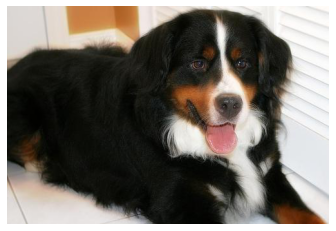

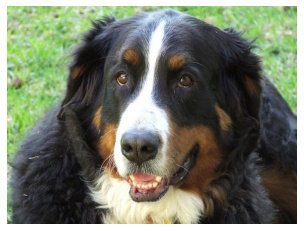

**Next mountain dog**

https://secondstorageaccountneha.blob.core.windows.net/secondcontainer/mountain_dog2.jpg


**Custom Vision Tags**

dog indoor animal laying front sitting brown looking computer lying large door bed keyboard standing desk playing kitchen

**Custom Vision Caption**

a large brown dog lying on the ground

**Most Similar**

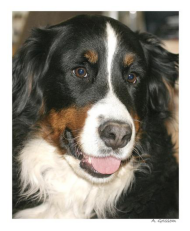

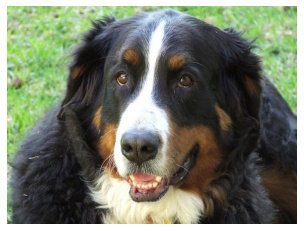

**Next mountain dog**

https://secondstorageaccountneha.blob.core.windows.net/secondcontainer/mountain_dog3.jpg


**Custom Vision Tags**

dog grass outdoor animal sitting mammal brown standing leash small laying front holding water close large woman man

**Custom Vision Caption**

a close up of a dog

**Most Similar**

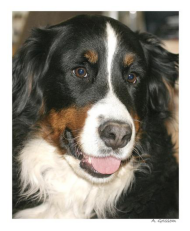

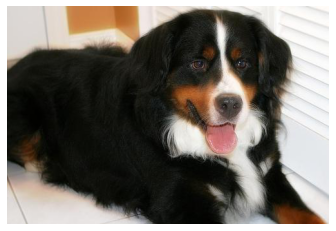

**Next mountain dog**

https://secondstorageaccountneha.blob.core.windows.net/secondcontainer/wilddog1.jpg5


HTTPError: HTTP Error 404: The specified blob does not exist.

In [11]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
import base64
import io
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import Markdown, display
import ntpath
import urllib.request 


def printmd(string):
    display(Markdown(string))

SEARCH_ENDPOINT = "https://my-new-search-service-neha.search.windows.net"

search_term = "mountain dog"

index_name = INDEX_NAME
# Get the service endpoint and API key from the environment
endpoint = SEARCH_ENDPOINT

# Create a client
credential = AzureKeyCredential(API_KEY)
client = SearchClient(endpoint=endpoint,
                      index_name=index_name,
                      credential=credential)


results = client.search(search_text=search_term, top=30)

for result in results:
    try:
        dog = str(base64.urlsafe_b64decode(result["id"] + '=' * (4 - len(result["id"]) % 4)))
    except Exception as InvalidBase64:
        continue
    dog_index = str(dog).find("dogs/")
    image_path =  dog[dog_index+3:].replace("\\r", "").replace("'", "")
    print(image_path)
    urllib.request.urlretrieve(image_path, "gfg.png")
    img = Image.open("gfg.png")
    img.show()

    # try:
    #     image_data = open(image_path, "rb").read()
    #     image = Image.open(BytesIO(image_data))
    # except Exception as FileExt:
    #     image_data = open(image_path[:-1], "rb").read()
    #     image = Image.open(BytesIO(image_data))
    # plt.imshow(image)
    # plt.axis("off")
    # _ = plt.title("", size="x-large", y=-0.1)
    # plt.show()
    
    printmd('**Custom Vision Tags**')
    printmd(' '.join(result['description'][0]['tags']))
    
    printmd('**Custom Vision Caption**')
    printmd(result['description'][0]['captions'][0]['text'])
    
    printmd('**Most Similar**')

    ms = result['most_similar'][0].replace("[", "").replace("]", "").split(",")
    for similiar_dog in ms:
        if ntpath.basename(similiar_dog).replace('"', '') == ntpath.basename(image_path).replace('"', '') or ntpath.basename(similiar_dog).replace('"', '') == ntpath.basename(image_path)[:-1].replace('"', ''):
            continue
        simage_data = open(os.path.join(similiar_dog.replace('"', '')), "rb").read()
        simage = Image.open(BytesIO(simage_data))
        plt.imshow(simage)
        plt.axis("off")
        _ = plt.title("", size="x-small", y=-0.4)
        plt.show()
    printmd(f'**Next {search_term}**')